## Selección de dataset

In [1]:
import pandas as pd  # Librería para manipulación y análisis de datos

# Cargar los datasets
df_only_trivial = pd.read_csv('datasets/OnlyTrivial_dt.csv') # Cargar el dataset de casos triviales
df_only_non_trivial = pd.read_csv('datasets/OnlyNonTrivial_dt.csv') # Cargar el dataset de casos no triviales

# Seleccionar el dataset y crear una copia explícita
dataset = df_only_trivial.copy() # Seleccionar el dataset de casos triviales y crear una copia para manipularlo

### Información de dataset

In [2]:
# Mostrar las primeras filas del dataset
dataset.head()

,refactoring,file,class,type,cbo,cboModified,fanin,fanout,wmc,dit,...,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty
0,1,\DATASET\abfiles\r0\c15\after\Main.java,mtgdeckbuilder.Main,class,0,0,0,0,2,1,...,0,0,0,1,1,0,0,12,1,0
1,1,\DATASET\abfiles\r0\c15\after\SearchButtonPane...,mtgdeckbuilder.frontend.SearchButtonPanel$Anon...,anonymous,2,2,0,2,2,1,...,1,0,1,1,0,0,0,15,-1,0
2,1,\DATASET\abfiles\r0\c15\after\SearchButtonPane...,mtgdeckbuilder.frontend.SearchButtonPanel$Stat...,innerclass,1,1,0,1,4,1,...,1,3,1,0,0,0,0,15,2,0
3,1,\DATASET\abfiles\r0\c15\after\MainFrame.java,mtgdeckbuilder.frontend.MainFrame$Anonymous1,anonymous,0,0,0,0,1,1,...,0,0,0,0,0,0,0,7,-1,0
4,1,\DATASET\abfiles\r0\c15\after\MainFrame.java,mtgdeckbuilder.frontend.MainFrame$Anonymous2,anonymous,0,0,0,0,1,1,...,0,0,0,0,0,0,0,5,-1,0


In [3]:
# Mostrar la información del dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232468 entries, 0 to 232467
Data columns (total 53 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   refactoring             232468 non-null  int64  
 1   file                    232468 non-null  object 
 2   class                   232468 non-null  object 
 3   type                    232468 non-null  object 
 4   cbo                     232468 non-null  int64  
 5   cboModified             232468 non-null  int64  
 6   fanin                   232468 non-null  int64  
 7   fanout                  232468 non-null  int64  
 8   wmc                     232468 non-null  int64  
 9   dit                     232468 non-null  int64  
 10  noc                     232468 non-null  int64  
 11  rfc                     232468 non-null  int64  
 12  lcom                    232468 non-null  int64  
 13  lcom*                   222369 non-null  float64
 14  tcc                 

In [4]:
# Descripción estadística del dataset
dataset.describe()

,refactoring,cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,lcom,...,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty
count,232468.000000,232468.000000,232468.000000,232468.000000,232468.000000,232468.000000,232468.000000,232468.000000,232468.000000,232468.000000,...,232468.000000,232468.000000,232468.000000,232468.000000,232468.000000,232468.000000,232468.000000,232468.000000,232468.000000,232468.000000
mean,0.515637,5.918088,7.543124,1.624766,5.918359,8.748976,1.462748,0.118902,9.048824,60.292948,...,7.104268,1.377889,6.348594,0.834515,0.140535,0.223730,0.083409,36.781290,41.587917,0.549732
std,0.499757,6.909441,8.762764,4.565373,6.909476,18.162615,0.875009,0.876846,16.306993,2331.071288,...,15.285373,5.455254,12.861225,1.159507,3.740856,5.704153,1.195608,48.416495,198.565851,2.246544
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,0.000000,2.000000,2.000000,0.000000,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,0.000000
50%,1.000000,4.000000,5.000000,0.000000,4.000000,3.000000,1.000000,0.000000,3.000000,0.000000,...,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000,0.000000
75%,1.000000,8.000000,10.000000,2.000000,8.000000,9.000000,2.000000,0.000000,11.000000,4.000000,...,7.000000,1.000000,7.000000,1.000000,0.000000,0.000000,0.000000,46.000000,8.000000,0.000000
max,1.000000,192.000000,471.000000,469.000000,192.000000,666.000000,75.000000,25.000000,237.000000,221445.000000,...,333.000000,286.000000,369.000000,14.000000,406.000000,508.000000,143.000000,1247.000000,3073.000000,30.000000


array([[<Axes: title={'center': 'cbo'}>,
        <Axes: title={'center': 'cboModified'}>,
        <Axes: title={'center': 'fanin'}>],
       [<Axes: title={'center': 'fanout'}>,
        <Axes: title={'center': 'wmc'}>, <Axes: title={'center': 'dit'}>],
       [<Axes: title={'center': 'noc'}>, <Axes: title={'center': 'rfc'}>,
        <Axes: title={'center': 'lcom'}>],
       [<Axes: title={'center': 'lcom*'}>, <Axes: >, <Axes: >]],
      dtype=object)

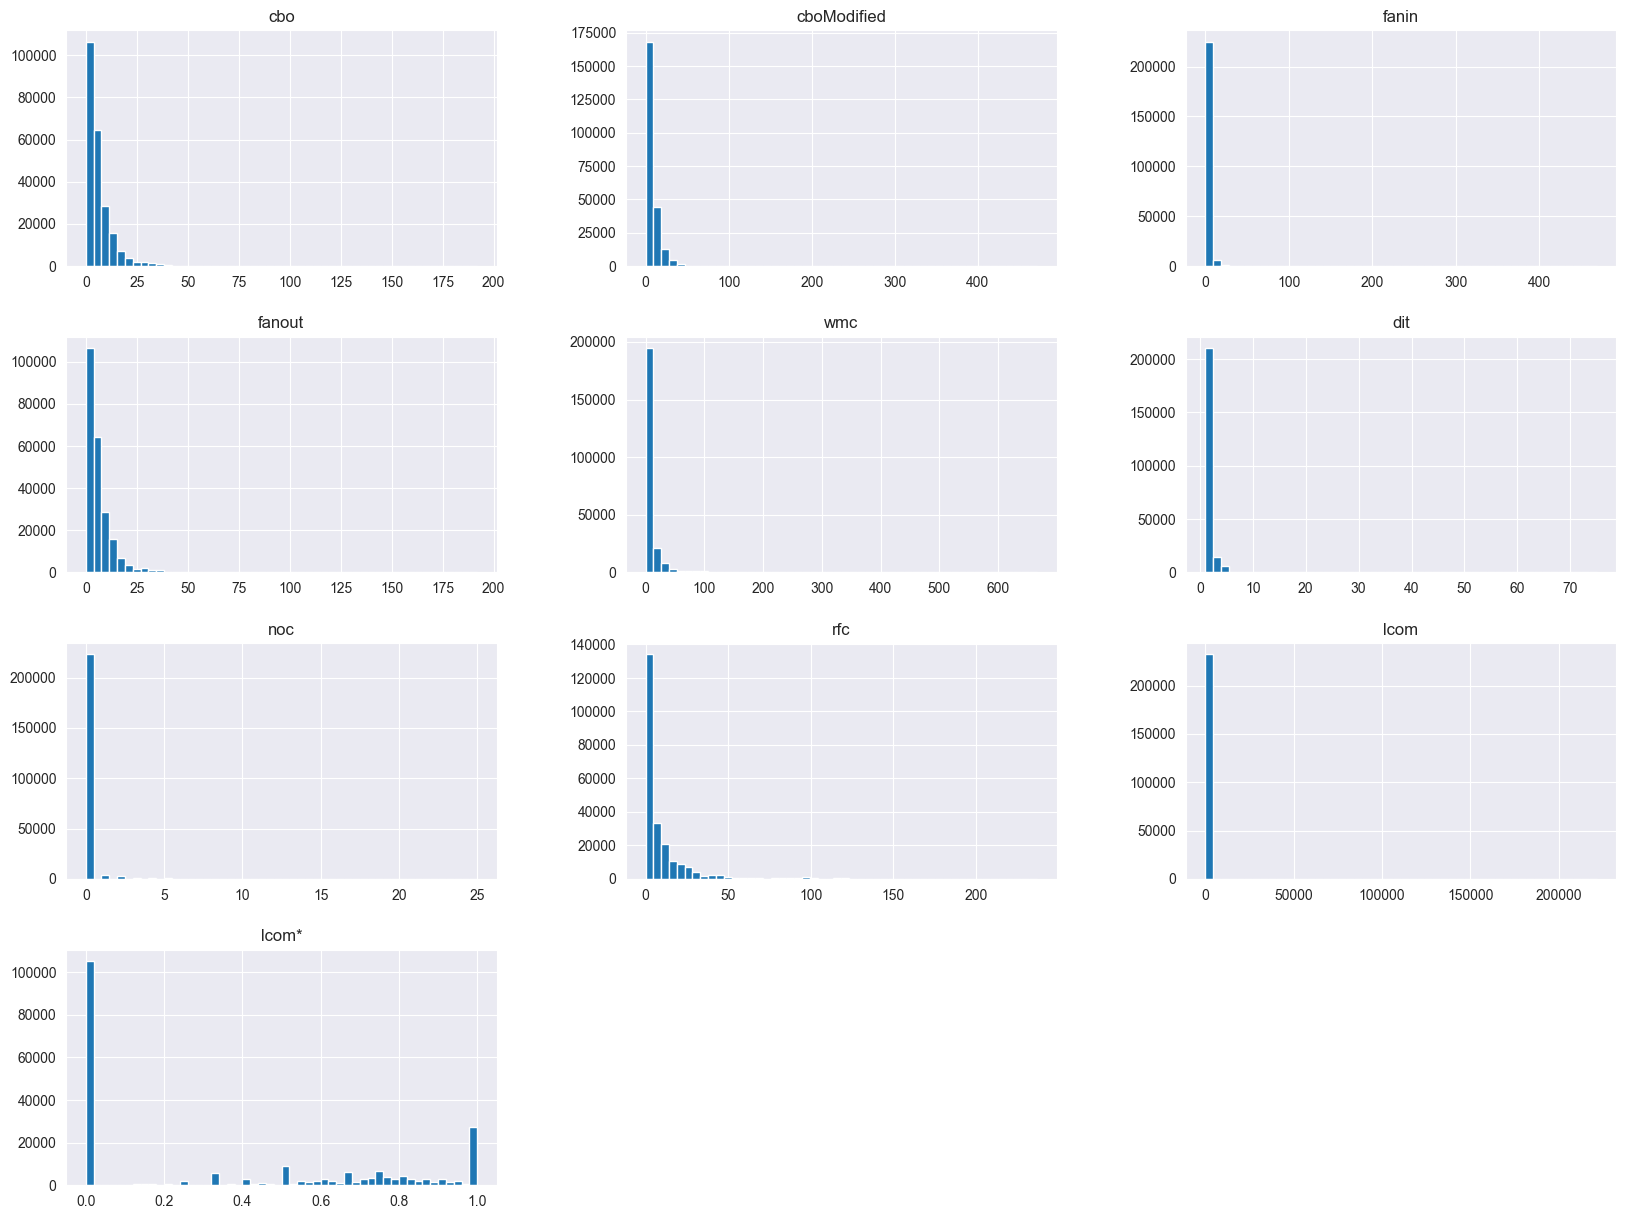

In [5]:
# Histograma de las características principales
principal_metrics = ['cbo', 'cboModified', 'fanin', 'fanout', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*']
# Generar histograma
dataset[principal_metrics].hist(bins=50, figsize=(20, 15))

## Conjunto de pruebas

In [6]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en un conjunto de entrenamiento y uno de prueba
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

# Mostrar la cantidad de datos en cada conjunto
print("Largo de conjuntos: ")
print("Entrenamiento: ", len(train_set))
print("Prueba: ", len(test_set))

Largo de conjuntos: 
Entrenamiento:  185974
Prueba:  46494


In [7]:
# Estabilización de los conjuntos de entrenamiento y prueba
import numpy as np
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

# Como el dataset no tiene una columna de identificación, se creará 
# una columna con el índice de cada fila
dataset_with_id = dataset.reset_index()
# Dividir el dataset en entrenamiento y prueba
train_set, test_set = split_train_test_by_id(dataset_with_id, 0.2, "index")

## Exploración

In [8]:
# Copia de dataset para manipulación
exploration_dataset = train_set.copy()

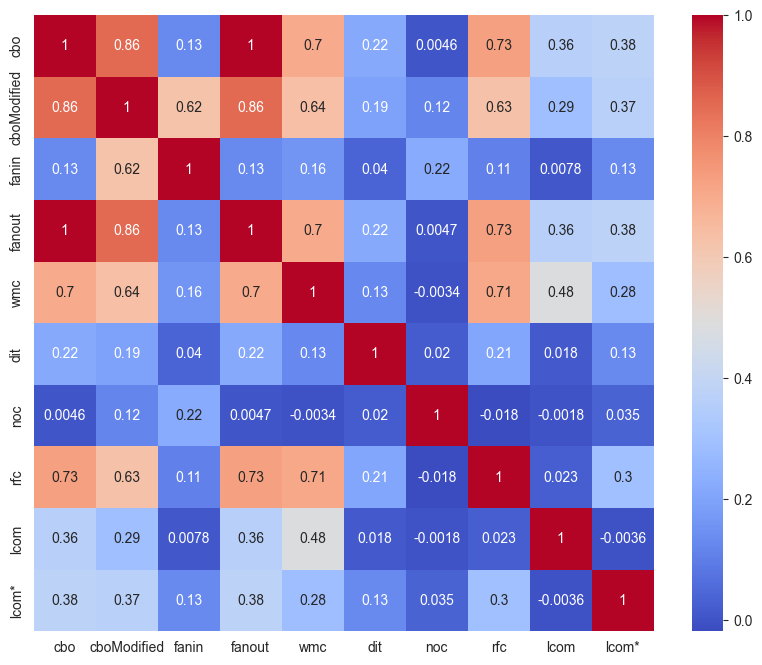

In [9]:
# Escalado de las características
import seaborn as sns  # Librería para visualización de datos
import matplotlib.pyplot as plt  # Importar matplotlib para visualización
from sklearn.preprocessing import StandardScaler  # Escalador
from sklearn.pipeline import Pipeline  # Pipeline para encadenar pasos

# Seleccionar las columnas a escalar
columns_to_scale = ['cbo', 'cboModified', 'fanin', 'fanout', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*']

# Asegurar que las columnas sean de tipo float64
exploration_dataset[columns_to_scale] = exploration_dataset[columns_to_scale].astype('float64')

# Crear un pipeline para el escalado
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Aplicar el escalado a las columnas seleccionadas
exploration_dataset[columns_to_scale] = pipeline.fit_transform(exploration_dataset[columns_to_scale])

# Mapa de calor de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(dataset[columns_to_scale].corr(), annot=True, cmap='coolwarm')
plt.show()